In [3]:
%load_ext autoreload
%autoreload 0

In [210]:
%autoreload

In [5]:
import sys
sys.path.append('/pollard/home/bsmith/Projects/haplo-benchmark/include/StrainFacts')

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from lib.pandas_util import idxwhere
import sfacts as sf
import numpy as np
import xarray as xr
import seaborn as sns
from scipy.spatial.distance import cdist
import lib.plot

In [213]:
species_id = '104345'
mgen_path = f'data/ucfmt.sp-{focal_species}.metagenotype.filt-poly05-cvrg05.nc'
scg_path = f'data/ucfmt.sp-{focal_species}.derep.genotype.nc'
fit_path = f'data/ucfmt.sp-{focal_species}.metagenotype.filt-poly05-cvrg05.fit-sfacts42-s30-g5000-seed0.refit-sfacts41-g10000-seed0.world.nc'
scg_to_sample_path = f'data/ucfmt.sp-{species_id}.derep.barcode_to_sample.tsv'
library_to_sample_path = "data/ucfmt.barcode_to_sample.tsv"
rabund_threshold = 0.01
pseudo = 0

q = 1

In [245]:
# mgen_path = sys.argv[1]
# scg_path = sys.argv[2]
# fit_path = sys.argv[3]
# scg_to_sample_path = sys.argv[4]
# library_to_sample_path = sys.argv[5]
# threshold = float(sys.argv[6])
# pseudo = float(sys.argv[7])  # e.g. 1e-10
# out_path = sys.argv[8]

mgen = sf.data.Metagenotypes.load(mgen_path)
drplt = sf.data.Metagenotypes.load(scg_path)
inference = sf.data.World.load(fit_path)

mgen_consensus = mgen.to_estimated_genotypes(pseudo=pseudo)
scg = drplt.to_estimated_genotypes(pseudo=pseudo)
inferred_geno = inference.genotypes
inferred_comm = inference.communities

position = list(set(scg.position.values) & set(inferred_geno.position.values))
mgen_consensus, scg, inferred_geno = [
    x.mlift("sel", position=position) for x in [mgen_consensus, scg, inferred_geno]
]

mgen_entropy = mgen.entropy("sample")
scg_entropy = drplt.entropy("sample")
comm_entropy = inferred_comm.entropy("sample")
geno_entropy = inferred_geno.entropy("strain")
scg_horizontal_coverage = drplt.horizontal_coverage()
mgen_horizontal_coverage = mgen.horizontal_coverage()

library_to_sample = pd.read_table(
    library_to_sample_path, index_col="barcode", squeeze=True
)
scg_to_sample = pd.read_table(
    scg_to_sample_path, names=["strain", "sample"], index_col="strain", squeeze=True
)
mgen_to_sample = library_to_sample.loc[mgen.sample]


fdist_any_strain = sf.match_genotypes(
    scg.to_world(), inferred_geno.to_world()
)[1]
ddist_any_strain = sf.match_genotypes(
    scg.to_world(), inferred_geno.discretized().to_world()
)[1]
adist_any_strain = sf.match_genotypes(
    scg.to_world(), inferred_geno.to_world(), cdist=lambda x, y: sf.math.genotype_cdist(x, y, q=q)
)[1]
fdist_any_mgen = sf.match_genotypes(
    scg.to_world(), mgen_consensus.to_world()
)[1]
ddist_any_mgen = sf.match_genotypes(
    scg.to_world(), mgen_consensus.discretized().to_world()
)[1]
adist_any_mgen = sf.match_genotypes(
    scg.to_world(), mgen_consensus.to_world(), cdist=lambda x, y: sf.math.genotype_cdist(x, y, q=q)
)[1]

out = []
for focal_mgen in idxwhere(mgen_to_sample.isin(scg_to_sample.unique())):
    focal_sample = mgen_to_sample[focal_mgen]
    focal_strains = idxwhere((inferred_comm.sel(sample=focal_mgen) > rabund_threshold).to_series())
    fdist_focal_strain = sf.match_genotypes(
        scg.to_world(), inferred_geno.mlift('sel', strain=focal_strains).to_world()
    )[1]
    ddist_focal_strain = sf.match_genotypes(
        scg.to_world(), inferred_geno.mlift('sel', strain=focal_strains).discretized().to_world()
    )[1]
    adist_focal_strain = sf.match_genotypes(
        scg.to_world(), inferred_geno.mlift('sel', strain=focal_strains).to_world(), cdist=lambda x, y: sf.math.genotype_cdist(x, y, q=q)
    )[1]
    fdist_focal_mgen = sf.match_genotypes(
        scg.to_world(), mgen_consensus.mlift('sel', strain=[focal_mgen]).to_world()
    )[1]
    ddist_focal_mgen = sf.match_genotypes(
        scg.to_world(), mgen_consensus.mlift('sel', strain=[focal_mgen]).discretized().to_world()
    )[1]
    adist_focal_mgen = sf.match_genotypes(
        scg.to_world(), mgen_consensus.mlift('sel', strain=[focal_mgen]).to_world(), cdist=lambda x, y: sf.math.genotype_cdist(x, y, q=q)
    )[1]
    for focal_scg in idxwhere(scg_to_sample == focal_sample):
        out.append(dict(
            scg=focal_scg,
            sample=focal_sample,
            mgen=focal_mgen,
            mgen_entropy=mgen_entropy.sel(sample=focal_mgen).values,
            mgen_horizontal_coverage=mgen_horizontal_coverage.sel(sample=focal_mgen).values,
            scg_entropy=scg_entropy.sel(sample=focal_scg).values,
            scg_horizontal_coverage=scg_horizontal_coverage.sel(sample=focal_scg).values,
            comm_entropy=comm_entropy.sel(sample=focal_mgen).values,
            fdist_any_strain=fdist_any_strain[focal_scg],
            ddist_any_strain=ddist_any_strain[focal_scg],
            adist_any_strain=adist_any_strain[focal_scg],
            fdist_any_mgen=fdist_any_mgen[focal_scg],
            ddist_any_mgen=ddist_any_mgen[focal_scg],
            adist_any_mgen=adist_any_mgen[focal_scg],
            fdist_focal_strain=fdist_focal_strain[focal_scg],
            ddist_focal_strain=ddist_focal_strain[focal_scg],
            adist_focal_strain=adist_focal_strain[focal_scg],
            fdist_focal_mgen=fdist_focal_mgen[focal_scg],
            ddist_focal_mgen=ddist_focal_mgen[focal_scg],
            adist_focal_mgen=adist_focal_mgen[focal_scg],
    ))
out = pd.DataFrame(out)

out

/opt/conda/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: divide by zero encountered in log2
  result_data = func(*input_data)
/opt/conda/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: divide by zero encountered in log2
  result_data = func(*input_data)


KeyboardInterrupt: 

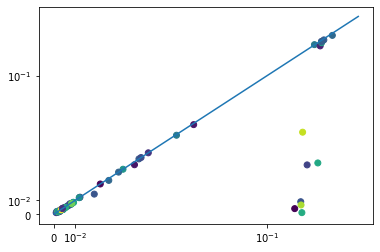

In [219]:
plt.scatter('x', 'y', data=out[out.scg_horizontal_coverage > 0.05].assign(x=lambda x: x.ddist_focal_mgen, y=lambda y: y.ddist_focal_strain), c='scg_horizontal_coverage')
plt.plot([0, 0.3], [0, 0.3])
plt.xscale('symlog', linthresh=1e-2, linscale=0.1)
plt.yscale('symlog', linthresh=1e-2, linscale=0.1)

/pollard/home/bsmith/Projects/haplo-benchmark/include/StrainFacts/sfacts/math.py:26: RuntimeWarning: invalid value encountered in double_scalars
  wmean_dist = ((weight * dist).sum()) / ((weight.sum()))


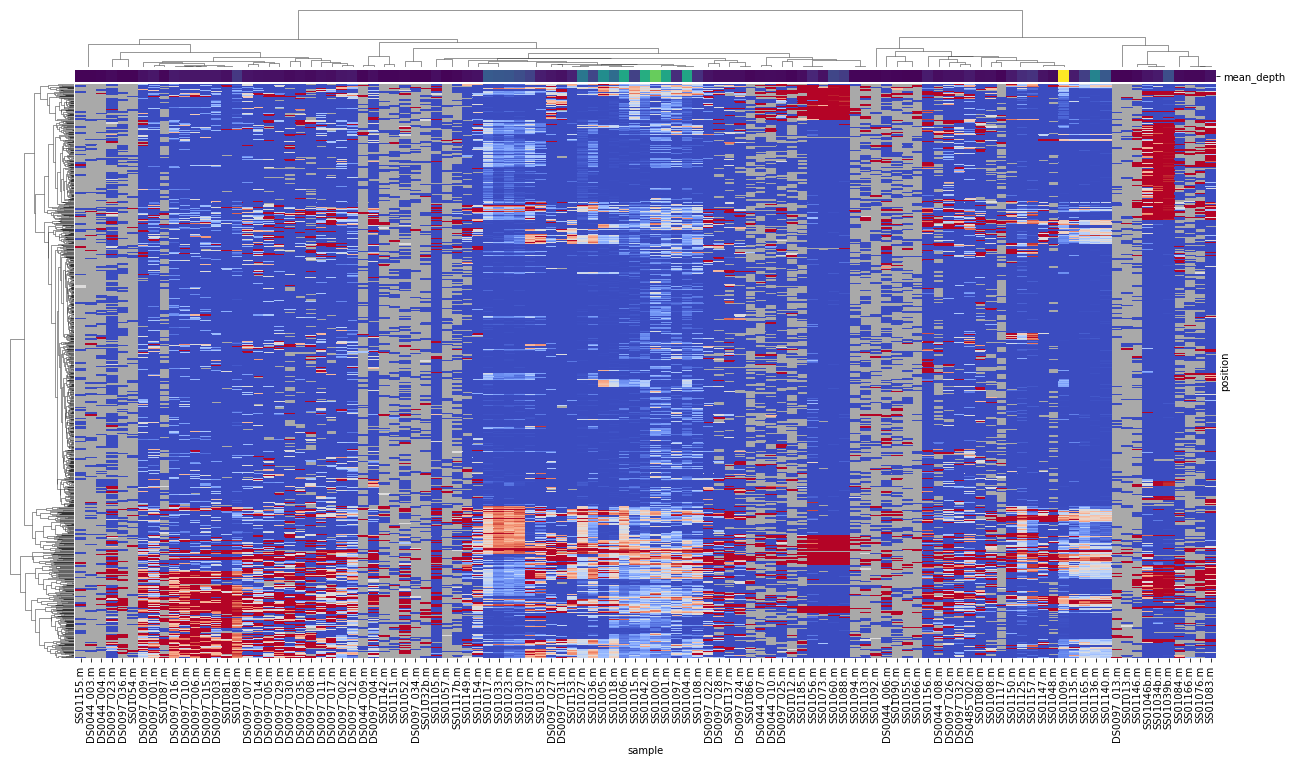

In [45]:
sf.plot.plot_metagenotype2(mgen.random_sample(position=1000))

In [671]:
focal_species = '104345'
# mgen_path = f'data/ucfmt.sp-{focal_species}.metagenotype.filt-poly05-cvrg05.nc'
scg_path = f'data/ucfmt.sp-{focal_species}.derep.genotype.nc'
fit_path = f'data/ucfmt.sp-{focal_species}.metagenotype.filt-poly05-cvrg05.fit-sfacts43-s30-g5000-seed3.refit-sfacts41-g10000-seed0.world.nc'

scg_to_sample_path = f'data/ucfmt.sp-{focal_species}.derep.barcode_to_sample.tsv'
library_to_sample_path = 'data/ucfmt.barcode_to_sample.tsv'
threshold = 0.01
pseudo = 1e-10
scg_cvrg_thresh = 0.05

scg_to_sample = pd.read_table(scg_to_sample_path, names=['scg', 'sample_id'], index_col='scg')
library_to_sample = pd.read_table(library_to_sample_path).rename(columns={'barcode': 'mgen'}).set_index('mgen')

# mgen = sf.data.Metagenotypes.load(mgen_path)
drplt = sf.data.Metagenotypes.load(scg_path)
inference = sf.data.World.load(fit_path)
inference.data['p'] = inference.data['communities'] @ inference.data['genotypes']
inference.data['m'] = inference.metagenotypes.total_counts()

inferred_community = inference.communities
shared_position = list(set(inference.position.values) & set(drplt.position.values))

consensus = inference.metagenotypes.to_estimated_genotypes(pseudo=pseudo).mlift('sel', position=shared_position)
scg = drplt.select_samples_with_coverage(scg_cvrg_thresh).to_estimated_genotypes(pseudo=pseudo).mlift('sel', position=shared_position)
inferred_genotype = inference.genotypes.mlift('sel', position=shared_position)